# STEP:1 IEMOCAP Dataset Directory Structure

In [2]:
import os

IEMOCAP_ROOT = "IEMOCAP_full_release"  # <-- Adjust if needed

def print_dir_structure(root, max_depth=3, prefix=''):
    for root_dir, dirs, files in os.walk(root):
        depth = root_dir[len(root):].count(os.sep)
        if depth > max_depth:
            continue
        print(f"{prefix}{os.path.relpath(root_dir, root)}")
        for f in files[:5]:
            if not f.startswith('.') and not f.startswith('._'):
                print(f"{prefix}  - {f}")
        if depth == max_depth:
            dirs[:] = []  # Stop deeper traversal

def print_sample_lines(file_path, num_lines=5):
    print(f"\nSample from {file_path}:")
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                print(line.strip())
                if i >= num_lines - 1:
                    break
    except Exception as e:
        print(f"Could not read file: {e}")

if __name__ == "__main__":
    print("==== IEMOCAP Directory Structure (up to depth 3) ====")
    print_dir_structure(IEMOCAP_ROOT, max_depth=3, prefix='  ')

    print("\n==== Sample Files from Session 1 ====")
    session1 = os.path.join(IEMOCAP_ROOT, "Session1")

    # EmoEvaluation
    emo_eval_dir = os.path.join(session1, "dialog", "EmoEvaluation")
    if os.path.exists(emo_eval_dir):
        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt') and not f.startswith('._')]
        if emo_files:
            print_sample_lines(os.path.join(emo_eval_dir, emo_files[0]))

    # Transcriptions
    trans_dir = os.path.join(session1, "dialog", "transcriptions")
    if os.path.exists(trans_dir):
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt') and not f.startswith('._')]
        if trans_files:
            print_sample_lines(os.path.join(trans_dir, trans_files[0]))

==== IEMOCAP Directory Structure (up to depth 3) ====
  .
  Documentation
  Session1
  Session1\dialog
  Session1\dialog\avi
  Session1\dialog\EmoEvaluation
  Session1\dialog\lab
  Session1\dialog\MOCAP_hand
  Session1\dialog\MOCAP_head
  Session1\dialog\MOCAP_rotated
  Session1\dialog\transcriptions
  Session1\dialog\wav
  Session1\sentences
  Session1\sentences\ForcedAlignment
  Session1\sentences\MOCAP_hand
  Session1\sentences\MOCAP_head
  Session1\sentences\MOCAP_rotated
  Session1\sentences\wav
  Session2
  Session2\dialog
  Session2\dialog\avi
  Session2\dialog\EmoEvaluation
  Session2\dialog\lab
  Session2\dialog\MOCAP_hand
  Session2\dialog\MOCAP_head
  Session2\dialog\MOCAP_rotated
  Session2\dialog\transcriptions
  Session2\dialog\wav
  Session2\sentences
  Session2\sentences\ForcedAlignment
  Session2\sentences\MOCAP_hand
  Session2\sentences\MOCAP_head
  Session2\sentences\MOCAP_rotated
  Session2\sentences\wav
  Session3
  Session3\dialog
  Session3\dialog\avi
  Session3\

# STEP 2: Parse the emotion labels and transcripts from the IEMOCAP Dataset for all 8 emotion classes. 

In [3]:
import os
import re
import pandas as pd

IEMOCAP_ROOT = "IEMOCAP_full_release"  # Adjust as needed

# Emotions to keep
EMOTIONS = {'sur', 'fea', 'fru', 'sad', 'hap', 'exc', 'neu', 'ang'}

def parse_emo_eval_file(file_path):
    """
    Parse an EmoEvaluation .txt file to extract utterance_id and emotion label.
    Returns a dict {utterance_id: emotion}
    """
    utterance_emotions = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            # Skip comments and empty lines
            if line.startswith('%') or not line.strip():
                continue
            # Match lines like: [6.2901 - 8.2357] Ses01F_impro01_F000 neu [2.5, 2.5, 2.5]
            match = re.match(r'\[(.*?) - (.*?)\]\s+(\S+)\s+(\S+)\s+\[.*\]', line)
            if match:
                utterance_id = match.group(3).strip()
                emotion = match.group(4).strip().lower()
                if emotion in EMOTIONS:
                    utterance_emotions[utterance_id] = emotion
    return utterance_emotions

def parse_transcript_file(file_path):
    """
    Parse a transcript .txt file to extract utterance_id and text.
    Returns a dict {utterance_id: text}
    """
    utterance_texts = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            # Match lines like: Ses01F_impro01_F000 [006.2901-008.2357]: Excuse me.
            match = re.match(r'(\S+)\s+\[.*\]:\s+(.*)', line)
            if match:
                utterance_id = match.group(1).strip()
                text = match.group(2).strip()
                utterance_texts[utterance_id] = text
    return utterance_texts

def load_iemocap_text_data(root_dir):
    """
    Load all utterance emotions and texts from IEMOCAP dataset.
    Returns a DataFrame with columns: utterance_id, emotion, text.
    """
    data = []
    for session in range(1, 6):  # Sessions 1 to 5
        emo_eval_dir = os.path.join(root_dir, f"Session{session}", "dialog", "EmoEvaluation")
        trans_dir = os.path.join(root_dir, f"Session{session}", "dialog", "transcriptions")
        if not os.path.exists(emo_eval_dir) or not os.path.exists(trans_dir):
            continue

        # List all emotion files and transcripts
        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt')]
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt')]

        for emo_file in emo_files:
            emo_path = os.path.join(emo_eval_dir, emo_file)
            utterance_emotions = parse_emo_eval_file(emo_path)

            # Find corresponding transcript file (same name)
            if emo_file in trans_files:
                trans_path = os.path.join(trans_dir, emo_file)
                utterance_texts = parse_transcript_file(trans_path)

                # Combine emotion and text for utterances present in both
                for utt_id, emo in utterance_emotions.items():
                    if utt_id in utterance_texts:
                        data.append({
                            'utterance_id': utt_id,
                            'emotion': emo,
                            'text': utterance_texts[utt_id]
                        })

    df = pd.DataFrame(data)
    return df

if __name__ == "__main__":
    df_text = load_iemocap_text_data(IEMOCAP_ROOT)
    print(f"Total utterances loaded: {len(df_text)}")
    print("Sample data:")
    print(df_text.head())

Total utterances loaded: 7527
Sample data:
          utterance_id emotion  \
0  Ses01F_impro01_F000     neu   
1  Ses01F_impro01_F001     neu   
2  Ses01F_impro01_F002     neu   
3  Ses01F_impro01_F005     neu   
4  Ses01F_impro01_F006     fru   

                                                text  
0                                         Excuse me.  
1                                              Yeah.  
2                                Is there a problem?  
3        Well what's the problem?  Let me change it.  
4  What?  I'm getting an ID.  This is why I'm her...  


# STEP 3: Creat the master CSV File and separate CSVs for text, audio and video modalities. 

In [4]:
import os
import re
import pandas as pd

IEMOCAP_ROOT = "IEMOCAP_full_release"  # Adjust as needed

# Emotions to keep and map to full names
EMOTIONS_MAP = {
    'sur': 'surprise',
    'fea': 'fear',
    'fru': 'frustration',
    'sad': 'sadness',
    'hap': 'happiness',
    'exc': 'excited',
    'neu': 'neutral',
    'ang': 'anger'
}

def parse_emo_eval_file(file_path):
    """
    Parse EmoEvaluation file to extract utterance info:
    utterance_id, emotion, start, end, dialogue
    """
    utterances = []
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            if line.startswith('%') or not line.strip():
                continue
            # Example line:
            # [6.2901 - 8.2357] Ses01F_impro01_F000 neu [2.5, 2.5, 2.5]
            match = re.match(r'\[(.*?) - (.*?)\]\s+(\S+)\s+(\S+)\s+\[.*\]', line)
            if match:
                start = float(match.group(1))
                end = float(match.group(2))
                utt_id = match.group(3).strip()
                emotion_abbr = match.group(4).strip().lower()
                if emotion_abbr in EMOTIONS_MAP:
                    # Extract dialogue name from utterance id (e.g. Ses01F_impro01 from Ses01F_impro01_F000)
                    dialogue = '_'.join(utt_id.split('_')[:-1])
                    utterances.append({
                        'utterance_id': utt_id,
                        'emotion': EMOTIONS_MAP[emotion_abbr],
                        'start': start,
                        'end': end,
                        'dialogue': dialogue
                    })
    return utterances

def parse_transcript_file(file_path):
    """
    Parse transcript file to get utterance_id -> text mapping
    """
    utterance_texts = {}
    with open(file_path, 'r', encoding='latin1') as f:
        for line in f:
            match = re.match(r'(\S+)\s+\[.*\]:\s+(.*)', line)
            if match:
                utt_id = match.group(1).strip()
                text = match.group(2).strip()
                utterance_texts[utt_id] = text
    return utterance_texts

def build_master_table(root_dir):
    data = []
    for session_num in range(1, 6):
        session_name = f"Session{session_num}"
        emo_eval_dir = os.path.join(root_dir, session_name, "dialog", "EmoEvaluation")
        trans_dir = os.path.join(root_dir, session_name, "dialog", "transcriptions")
        audio_base_dir = os.path.join(root_dir, session_name, "sentences", "wav")
        video_base_dir = os.path.join(root_dir, session_name, "dialog", "avi", "DivX")

        if not os.path.exists(emo_eval_dir) or not os.path.exists(trans_dir):
            print(f"Skipping {session_name} due to missing directories.")
            continue

        emo_files = [f for f in os.listdir(emo_eval_dir) if f.endswith('.txt')]
        trans_files = [f for f in os.listdir(trans_dir) if f.endswith('.txt')]

        for emo_file in emo_files:
            emo_path = os.path.join(emo_eval_dir, emo_file)
            utterances = parse_emo_eval_file(emo_path)

            # Corresponding transcript file
            if emo_file not in trans_files:
                continue
            trans_path = os.path.join(trans_dir, emo_file)
            utterance_texts = parse_transcript_file(trans_path)

            # For each utterance, collect all info and paths
            for utt in utterances:
                utt_id = utt['utterance_id']
                if utt_id not in utterance_texts:
                    continue
                text = utterance_texts[utt_id]

                # Audio path: sentences/wav/<dialogue>/<utt_id>.wav
                audio_path = os.path.join(audio_base_dir, utt['dialogue'], f"{utt_id}.wav")
                if not os.path.exists(audio_path):
                    audio_path = ""  # or None if missing

                # Video path: dialog/avi/DivX/<dialogue>.avi
                video_path = os.path.join(video_base_dir, f"{utt['dialogue']}.avi")
                if not os.path.exists(video_path):
                    video_path = ""

                data.append({
                    'session': session_name,
                    'dialogue': utt['dialogue'],
                    'utterance_id': utt_id,
                    'start': utt['start'],
                    'end': utt['end'],
                    'text': text,
                    'emotion': utt['emotion'],
                    'audio_path': audio_path,
                    'video_dialog_path': video_path
                })

    df_master = pd.DataFrame(data)
    return df_master

if __name__ == "__main__":
    df_master = build_master_table(IEMOCAP_ROOT)
    print(f"Total utterances in master table: {len(df_master)}")
    print(df_master.head())

    # Save master CSV
    master_csv_path = "iemocap_master_table.csv"
    df_master.to_csv(master_csv_path, index=False)
    print(f"Master CSV saved to {master_csv_path}")

    # Save modality-specific CSVs

    # Text only
    df_text = df_master[['utterance_id', 'text', 'emotion']]
    df_text.to_csv("iemocap_text.csv", index=False)
    print("Text CSV saved.")

    # Audio only
    df_audio = df_master[['utterance_id', 'audio_path', 'emotion']]
    df_audio.to_csv("iemocap_audio.csv", index=False)
    print("Audio CSV saved.")

    # Video only
    df_video = df_master[['utterance_id', 'video_dialog_path', 'emotion']]
    df_video.to_csv("iemocap_video.csv", index=False)
    print("Video CSV saved.")

Total utterances in master table: 7527
    session        dialogue         utterance_id    start      end  \
0  Session1  Ses01F_impro01  Ses01F_impro01_F000   6.2901   8.2357   
1  Session1  Ses01F_impro01  Ses01F_impro01_F001  10.0100  11.3925   
2  Session1  Ses01F_impro01  Ses01F_impro01_F002  14.8872  18.0175   
3  Session1  Ses01F_impro01  Ses01F_impro01_F005  27.4600  31.4900   
4  Session1  Ses01F_impro01  Ses01F_impro01_F006  38.9650  43.5900   

                                                text      emotion  \
0                                         Excuse me.      neutral   
1                                              Yeah.      neutral   
2                                Is there a problem?      neutral   
3        Well what's the problem?  Let me change it.      neutral   
4  What?  I'm getting an ID.  This is why I'm her...  frustration   

                                          audio_path  \
0  IEMOCAP_full_release\Session1\sentences\wav\Se...   
1  IEMOCAP_fu

In [6]:
from sklearn.utils import resample

# Balance the master table using oversampling
def balance_dataset(df, label_col='emotion'):
    df_balanced = pd.DataFrame()
    min_class_size = df[label_col].value_counts().min()
    
    # Get max class size for full oversampling (or use min_class_size for undersampling)
    max_class_size = df[label_col].value_counts().max()

    for emotion in df[label_col].unique():
        df_emotion = df[df[label_col] == emotion]
        df_upsampled = resample(df_emotion,
                                replace=True,
                                n_samples=max_class_size,  # change to min_class_size if you want undersampling
                                random_state=42)
        df_balanced = pd.concat([df_balanced, df_upsampled])

    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# Apply it
df_master_balanced = balance_dataset(df_master)

# Save the new balanced master CSV
df_master_balanced.to_csv("iemocap_master_table_balanced.csv", index=False)
print("Balanced master CSV saved.")

Balanced master CSV saved.


In [7]:
# Text only
df_text = df_master_balanced[['utterance_id', 'text', 'emotion']]
df_text.to_csv("iemocap_text_balanced.csv", index=False)
print("Balanced text CSV saved.")

# Audio only
df_audio = df_master_balanced[['utterance_id', 'audio_path', 'emotion']]
df_audio.to_csv("iemocap_audio_balanced.csv", index=False)
print("Balanced audio CSV saved.")

# Video only
df_video = df_master_balanced[['utterance_id', 'video_dialog_path', 'emotion']]
df_video.to_csv("iemocap_video_balanced.csv", index=False)
print("Balanced video CSV saved.")

Balanced text CSV saved.
Balanced audio CSV saved.
Balanced video CSV saved.


# STEP 4: Text preprocessing and Feature Extraction

In [8]:
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load balanced text CSV
df = pd.read_csv("iemocap_text_balanced.csv")


# Text cleaning function
def clean_text(text):
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Optionally, remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# TF-IDF Vectorizer (limit max features for CPU efficiency)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Labels
y = df['emotion']

# Split into train and test sets (e.g., 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"TF-IDF feature matrix shape: {X_tfidf.shape}")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Save TF-IDF vectorizer and datasets if needed
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.joblib'")

# Optionally save train/test splits (sparse matrices)
import scipy.sparse
scipy.sparse.save_npz("X_train_tfidf.npz", X_train)
scipy.sparse.save_npz("X_test_tfidf.npz", X_test)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Train/test splits saved.")

TF-IDF feature matrix shape: (14792, 5000)
Training samples: 11833, Test samples: 2959
TF-IDF vectorizer saved as 'tfidf_vectorizer.joblib'
Train/test splits saved.


# STEP 5: Train and Evaluate a Text-only classifier TF-IDF features + SVM Classifier

Test Accuracy: 0.8168
Test Macro F1-score: 0.8138

Classification Report:
              precision    recall  f1-score   support

       anger       0.82      0.80      0.81       370
     excited       0.83      0.76      0.80       369
        fear       0.95      1.00      0.97       370
 frustration       0.72      0.66      0.69       370
   happiness       0.82      0.84      0.83       370
     neutral       0.71      0.65      0.68       370
     sadness       0.79      0.84      0.81       370
    surprise       0.86      0.99      0.92       370

    accuracy                           0.82      2959
   macro avg       0.81      0.82      0.81      2959
weighted avg       0.81      0.82      0.81      2959



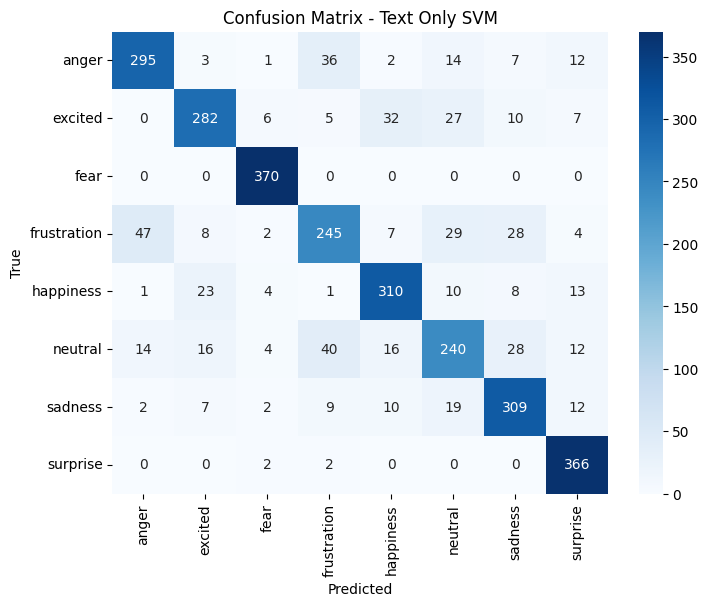

In [9]:
import joblib
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns

# Load train/test data
X_train = scipy.sparse.load_npz("X_train_tfidf.npz")
X_test = scipy.sparse.load_npz("X_test_tfidf.npz")
y_train = pd.read_csv("y_train.csv")['emotion']
y_test = pd.read_csv("y_test.csv")['emotion']

# Initialize and train Linear SVM
clf = LinearSVC(random_state=42, max_iter=10000)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Macro F1-score: {f1_macro:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Text Only SVM')
plt.show()

# Saving the Model

In [10]:
# Save the trained model
model_filename = "svm_text_classifier.joblib"
joblib.dump(clf, model_filename)
print(f"Model saved as {model_filename}")

# Also save the class labels in case you need them later
class_labels_filename = "svm_class_labels.joblib"
joblib.dump(clf.classes_, class_labels_filename)
print(f"Class labels saved as {class_labels_filename}")

Model saved as svm_text_classifier.joblib
Class labels saved as svm_class_labels.joblib


# Loading and Using the Saved Model

In [11]:
import joblib
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Load the vectorizer (needed to transform new text)
tfidf = joblib.load("tfidf_vectorizer.joblib")

# 2. Load the trained model
clf_loaded = joblib.load("svm_text_classifier.joblib")

# 3. Load class labels if needed
class_labels = joblib.load("svm_class_labels.joblib")

In [12]:
# Example usage on new text:
def predict_emotion(text):
    # Clean the text (same cleaning as during training)
    def clean_text(text):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = ' '.join(text.split())
        return text
    
    cleaned_text = clean_text(text)
    
    # Transform text to TF-IDF features
    text_tfidf = tfidf.transform([cleaned_text])
    
    # Predict
    prediction = clf_loaded.predict(text_tfidf)
    probabilities = clf_loaded.decision_function(text_tfidf)
    
    return prediction[0], probabilities

# Test prediction
sample_text = "Good God.."
emotion, scores = predict_emotion(sample_text)
print(f"Predicted emotion: {emotion}")

Predicted emotion: fear


In [13]:
# Re-load existing model and vectorizer
clf = joblib.load("svm_text_classifier.joblib")
tfidf = joblib.load("tfidf_vectorizer.joblib")

# Save them with new names for your multimodal app
joblib.dump(clf, "text_model.pkl")
joblib.dump(tfidf, "text_vectorizer.pkl")

print("Saved as text_model.pkl and text_vectorizer.pkl ✅")

Saved as text_model.pkl and text_vectorizer.pkl ✅


# STEP 6: BERT Pipeline Code:-

In [11]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.optim import AdamW  # Use PyTorch native AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from tqdm.auto import tqdm  # tqdm for progress bars
import os
import json


# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load balanced text data
df = pd.read_csv("iemocap_text_balanced.csv")


# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['emotion'])
num_labels = len(label_encoder.classes_)
print(f"Labels: {list(label_encoder.classes_)}")

df['id'] = df.index.astype(str)  # Create unique IDs as string

train_texts, val_texts, train_labels, val_labels, train_ids, val_ids = train_test_split(
    df['text'].tolist(), df['label'].tolist(), df['id'].tolist(),
    test_size=0.2, random_state=42, stratify=df['label']
)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label']
)

# Tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

class IEMOCAPDataset(Dataset):
    def __init__(self, texts, labels, ids, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.ids = ids
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        utt_id = self.ids[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long),
            'utterance_id': utt_id
        }


# Create datasets and dataloaders
train_dataset = IEMOCAPDataset(train_texts, train_labels, train_ids, tokenizer)
val_dataset = IEMOCAPDataset(val_texts, val_labels, val_ids, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.to(device)

# Optimizer (PyTorch native AdamW)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function with tqdm progress bar
def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    loop = tqdm(data_loader, desc="Training", leave=False)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
    return total_loss / len(data_loader)

# Evaluation function with tqdm progress bar
def eval_model(model, data_loader):
    model.eval()
    preds = []
    true_labels = []
    loop = tqdm(data_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='macro')
    report = classification_report(true_labels, preds, target_names=label_encoder.classes_)
    return acc, f1, report


def extract_cls_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    utterance_ids = []

    loop = tqdm(data_loader, desc="Extracting CLS embeddings", leave=False)
    with torch.no_grad():
        for batch in loop:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model.bert(input_ids, attention_mask=attention_mask)
            cls_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()

            embeddings.append(cls_embeds)
            labels.extend(batch['labels'].cpu().numpy())
            utterance_ids.extend(batch['utterance_id'])

    embeddings = np.vstack(embeddings)
    return embeddings, np.array(labels), utterance_ids


# Training loop
epochs = 3
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_acc, val_f1, val_report = eval_model(model, val_loader)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Acc: {val_acc:.4f} - Val F1: {val_f1:.4f}")

print("\nValidation Classification Report:\n", val_report)

# Save fine-tuned model and tokenizer
model.save_pretrained("bert_finetuned_iemocap")
tokenizer.save_pretrained("bert_finetuned_iemocap")
print("Model and tokenizer saved to 'bert_finetuned_iemocap'")


# Extract CLS embeddings for train and val
train_embeddings, train_labels_arr, train_utt_ids = extract_cls_embeddings(model, train_loader)
val_embeddings, val_labels_arr, val_utt_ids = extract_cls_embeddings(model, val_loader)

# Save to disk
np.save("train_embeddings.npy", train_embeddings)
np.save("train_labels.npy", train_labels_arr)
np.save("train_ids.npy", np.array(train_utt_ids))

np.save("val_embeddings.npy", val_embeddings)
np.save("val_labels.npy", val_labels_arr)
np.save("val_ids.npy", np.array(val_utt_ids))

# Save label map
label2id = {label: int(idx) for idx, label in enumerate(label_encoder.classes_)}
with open("fusion_data/label_map.json", "w") as f:
    json.dump(label2id, f)

print("✅ Fusion-ready data (CLS embeddings + labels + IDs) saved successfully!")

Using device: cpu
Labels: ['anger', 'excited', 'fear', 'frustration', 'happiness', 'neutral', 'sadness', 'surprise']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1/3 - Train Loss: 1.1663 - Val Acc: 0.7418 - Val F1: 0.7342


Training:   0%|          | 0/740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2/3 - Train Loss: 0.5817 - Val Acc: 0.8141 - Val F1: 0.8119


Training:   0%|          | 0/740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3/3 - Train Loss: 0.3803 - Val Acc: 0.8462 - Val F1: 0.8451

Validation Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.81      0.84       370
     excited       0.75      0.86      0.80       369
        fear       0.95      1.00      0.97       370
 frustration       0.77      0.74      0.75       370
   happiness       0.88      0.84      0.86       370
     neutral       0.76      0.71      0.73       370
     sadness       0.88      0.82      0.84       370
    surprise       0.93      0.99      0.96       370

    accuracy                           0.85      2959
   macro avg       0.85      0.85      0.85      2959
weighted avg       0.85      0.85      0.85      2959

Model and tokenizer saved to 'bert_finetuned_iemocap'


Extracting CLS embeddings:   0%|          | 0/740 [00:00<?, ?it/s]

Extracting CLS embeddings:   0%|          | 0/93 [00:00<?, ?it/s]

✅ Fusion-ready data (CLS embeddings + labels + IDs) saved successfully!


In [12]:
print("Train Embeddings Shape:", train_embeddings.shape)
print("Val Embeddings Shape:", val_embeddings.shape)
print("Train IDs Example:", train_utt_ids[:5])

Train Embeddings Shape: (11833, 768)
Val Embeddings Shape: (2959, 768)
Train IDs Example: ['6419', '14276', '2500', '9235', '10855']


# STEP 7: Code for Inference: Predict Emotion from user Input Text with Confidence Scores.

In [13]:
import torch
import numpy as np

# Load saved model and tokenizer
from transformers import BertTokenizerFast, BertForSequenceClassification

model_path = "bert_finetuned_iemocap"
tokenizer = BertTokenizerFast.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# Label encoder inverse mapping
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

def predict_emotion(text, true_label=None):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = np.argmax(probs)
        pred_label = label_map[pred_idx]
        confidence = probs[pred_idx]

    print(f"Input Text: {text}")
    if true_label:
        print(f"True Label: {true_label}")
    print(f"Predicted Emotion: {pred_label} (Confidence: {confidence:.4f})")
    print("All class probabilities:")
    for i, label in label_map.items():
        print(f"  {label}: {probs[i]:.4f}")
    return pred_label, confidence
   # predict_emotion("I am so happy and excited today!", true_label="happiness") # Example usage:

In [14]:
predict_emotion("Like what? Like a birth certificate?")

Input Text: Like what? Like a birth certificate?
Predicted Emotion: frustration (Confidence: 0.9098)
All class probabilities:
  anger: 0.0089
  excited: 0.0031
  fear: 0.0013
  frustration: 0.9098
  happiness: 0.0003
  neutral: 0.0666
  sadness: 0.0055
  surprise: 0.0046


('frustration', 0.9097658)

In [15]:
predict_emotion("You never listen to me, no matter how many times I say it!")

Input Text: You never listen to me, no matter how many times I say it!
Predicted Emotion: anger (Confidence: 0.7491)
All class probabilities:
  anger: 0.7491
  excited: 0.0016
  fear: 0.0005
  frustration: 0.2378
  happiness: 0.0009
  neutral: 0.0074
  sadness: 0.0020
  surprise: 0.0007


('anger', 0.7491241)

In [16]:
#!pip install wordcloud

# STEP 8: Word Cloud per Session

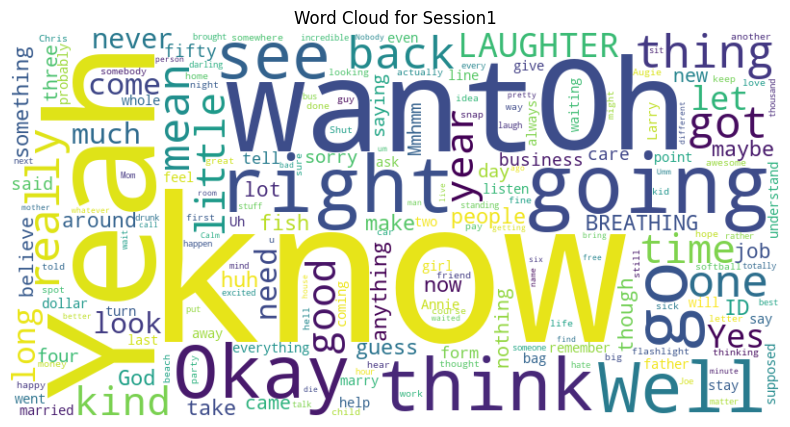

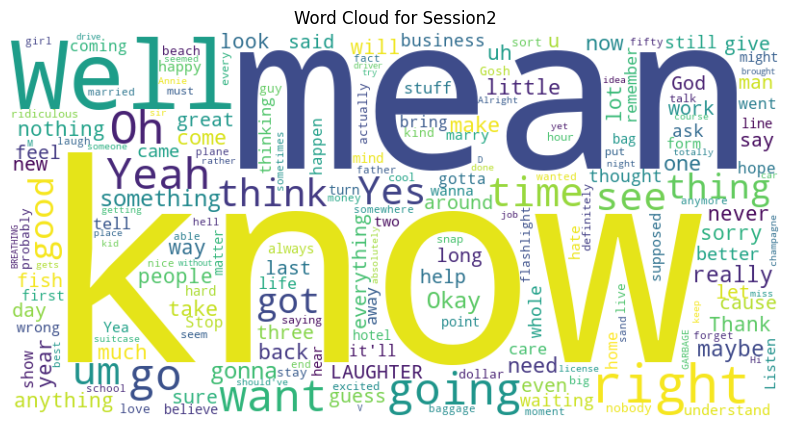

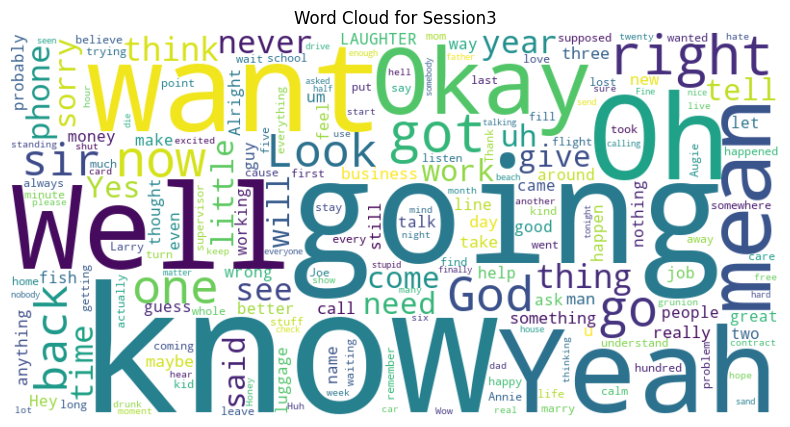

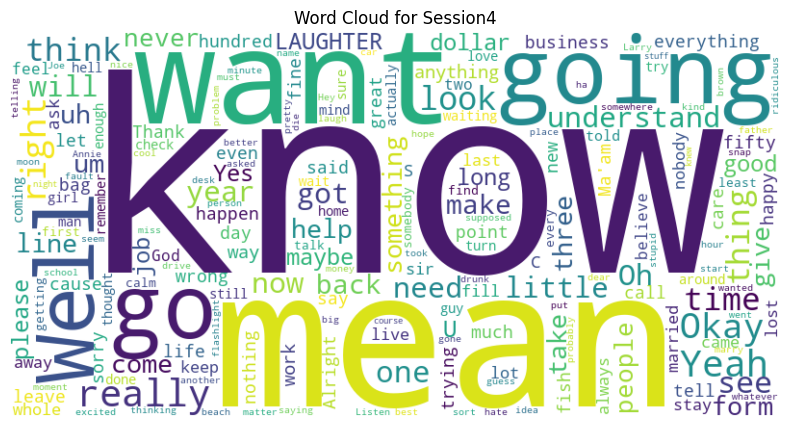

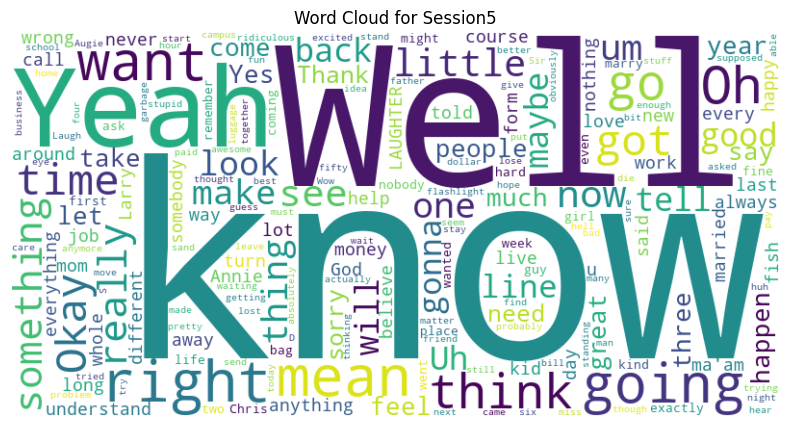

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Assuming df_master is your master dataframe with 'session' and 'text' columns
stopwords = set(STOPWORDS)

for session_name, group in df_master.groupby('session'):
    text = " ".join(group['text'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stopwords, collocations=False).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {session_name}")
    plt.show()